# Parsing Gating Information From WoodList 3 Analysis Files

## Getting to know the object table

PList (Apple's proprietary "Property List" file format) stores information in an "object table". This object table is just a list of objects in order of their ID numbers (referenced as a "UID"). This object table for any given WoodList 3 analysis file can be read into Python3 in the following way: 

In [57]:
# INSTRUCTIONS: Please copy a whole flow directory from the Pathology server to 
# your local computer. Ensure that the flow directory is a WoodList3 analysis 
# directory as there will be a file that ends in ".nlys". Your best bet will be 
# an F21 (from 2021) flow directory. I have not included this here as the MRN / Flow ID
# could be considered PHI
Woodlist_3_nlys_file = "<insert_file_here>.nlys"

# Download this file here: https://raw.githubusercontent.com/cclgroupltd/ccl-bplist/master/ccl_bplist.py
# and put the path of the folder it is contained in below
path_to_ccl_bplist_lib = '<path_to_ccl_bplit_dir>'

import sys
sys.path.append(path_to_ccl_bplist_lib)
import ccl_bplist

f = open(Woodlist_3_nlys_file, "rb")
plist = ccl_bplist.load(f)
object_table = plist['$objects']

### Accessing objects in the object table

Previously mentioned, we can access objects in the objects table by retrieving the index / UID of the object we would like. In this case, the objects might correspond to `GMPoints` objects. An example of how this might look in xml can be seen below.

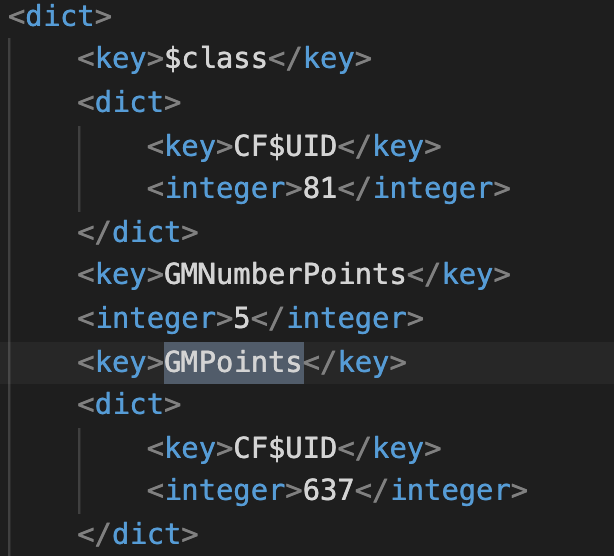

We can now access the object table at the index given by the UID seen within the `GMPoints` object.

In [58]:
object_table[637]

b'\x00\x00\x00\x80I\xab\xb8?\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\xa0\xc1\x10\xba?\x00\x00\x00\x00\x01\xca]\xbf\x00\x00\x00\x00\x00\xca=\xbf\x00\x00\x00\x00\x01\xca]\xbf\x00\x00\x00\x00\x00\xca=\xbf\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x80I\xab\xb8?\x00\x00\x00\x00\x00\x00\xf0?'

## Decoding GMPoints Objects

Reading the [docs for the Python3 struct module](https://docs.python.org/3/library/struct.html) shows us that we can use it to convert between Python values and C structs represented as Python bytes objects. From trial and error, we have found that the `GMPoints` objects are stored as **little endian 8-byte doubles**. Using this information, we can decode the example `GMPoints` object below. 

We see that corresponding to the `GMNumberPoints` key above, we have 5 (x,y) coordinates, or 10 total values.

In [59]:
# GMPoints_bytes = object_table[637]
# Hardcoded below for sake of example replicability
GMPoints_bytes = b'\x00\x00\x00\x80I\xab\xb8?\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\xa0\xc1\x10\xba?\x00\x00\x00\x00\x01\xca]\xbf\x00\x00\x00\x00\x00\xca=\xbf\x00\x00\x00\x00\x01\xca]\xbf\x00\x00\x00\x00\x00\xca=\xbf\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x80I\xab\xb8?\x00\x00\x00\x00\x00\x00\xf0?'
GMPoints = struct.unpack('<' + 'd' * (len(list(GMPoints_bytes)) // 8), GMPoints_bytes)
GMPoints

(0.09636363387107849,
 1.0,
 0.10181818157434464,
 -0.0018181810155510902,
 -0.0004545450210571289,
 -0.0018181810155510902,
 -0.0004545450210571289,
 1.0,
 0.09636363387107849,
 1.0)

In [60]:
len(GMPoints)

10

We can see an example performed on a different `GMPoints` object below. This decoding was compared with its corresponding pane in WoodList 3 (by opening the analysis file with WoodList 3). We can be confident that our decoding is correct as the points at the top of the pane correspond with the y-values of `1.0` seen in the `GMPoints` decoding in the image

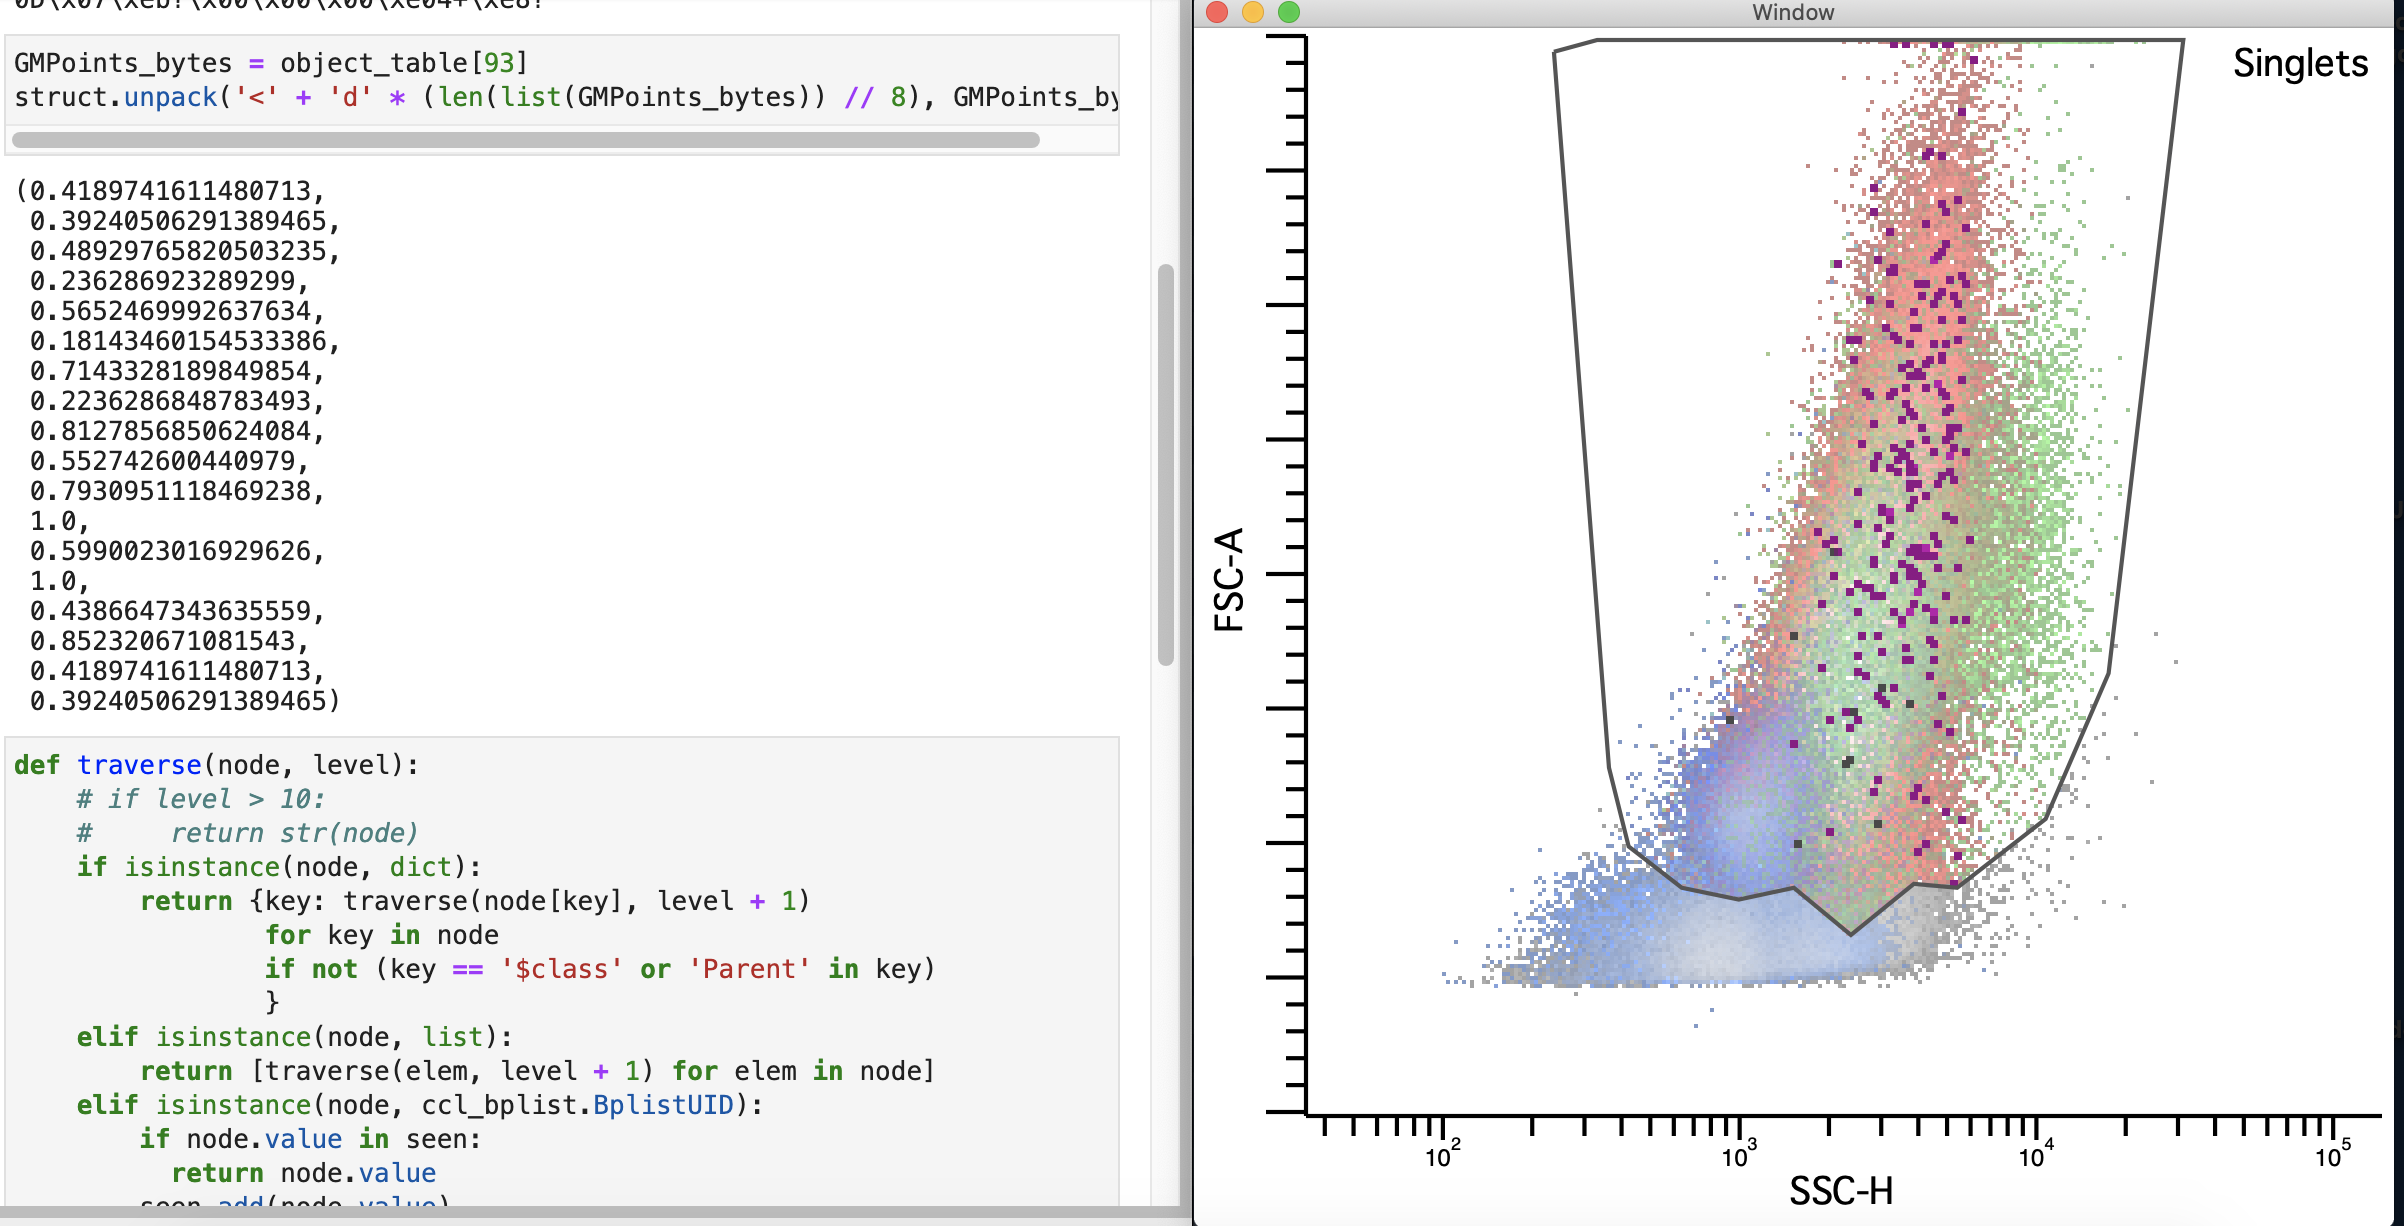

## GMPoints Encoding

From the example above, the encoding of the points does appear to be an (x,y,x,y,x,y,...,x,y) encoding, and the values are little endian 8 byte doubles ("<d" args to struct.unpack). They also appear to be encoding in (0,1) range, thus more computation will be needed to extract the correct value for the gates. 

Currently, we believe that the `[0,1]` range is normalized / proportional to the maximum feature value observed. Some caveats are that the feature values could be

* Compensated or Uncompensated (most likely they are compensated)
* Normalized to the maximum feature value **that is found within the gate**. This means that we will have to keep track of any prior gating even when we are converting the gating polygon points to measured FCS feature space.

## Parsing the gating tree (relationship between gates)

The `create_gates_tree()` function below has been adapted from Menglei Zhu's (Pathology) provided code in order to parse the relationship between gates. The modifications that I have made allow this process to parsing to start from any given object UID as opposed to requiring the whole object table structure to be parsed and navigated beforehand.

Note that currently the line `points = {'data': xy}` is commented out, to allow us to more easily see the structure of the gating tree when printed. For the final version, a better-parsed list of `(x,y)` polygon points should probably be inserted here.

Also note that this is a recrusive function that relies on three global variables (`gate_index`, `total_gates` and `gates`)

In [61]:
def create_gates_tree(gate, level):  
  global gate_index
  global total_gates
  global gates
  
  name_uid = int(str(gate['PEName']).split(': ')[1])
  name = object_table[name_uid]
  
  pe_method_uid = int(str(gate['PEMethod']).split(': ')[1])
  pe_method = object_table[pe_method_uid]
  
  points = {}
  if 'GMPoints' in pe_method:
    gm_points_uid = int(str(pe_method['GMPoints']).split(': ')[1])
    gm_points = object_table[gm_points_uid]
    xy = struct.unpack('<' + 'd' * (len(list(gm_points)) // 8), gm_points)
    #     points = {'data': xy}
    points = ''

  children = []
  
  if gate_index + 1 < total_gates: 
    next_gate_uid = int(str(gates[gate_index + 1]).split(': ')[1])
    next_gate = object_table[next_gate_uid]
  
  while gate_index + 1 < total_gates and int(next_gate['PENestingLevel']) > level:
    gate_index += 1
    children.append(create_gates_tree(next_gate, level + 1))
          
  return {'name': name, 'children': children, 'points': points}

### Example for a single UID / gate tree

In [63]:
UID = 263

POPopulations = object_table[UID]

if 'NS.objects' in POPopulations: 
  gates = POPopulations['NS.objects']

  gate_index = 0
  total_gates = len(gates)

  first_gate_uid = int(str(gates[0]).split(': ')[1])
  first_gate = object_table[first_gate_uid]
  res = create_gates_tree(first_gate, gate_index)
  
res

{'name': 'All Events',
 'children': [{'name': 'TIME',
   'children': [{'name': 'Singlets',
     'children': [{'name': 'Viable',
       'children': [{'name': 'mononuclear',
         'children': [{'name': 'T cells',
           'children': [{'name': 'CD4',
             'children': [{'name': 'CD7 neg CD4 pos',
               'children': [{'name': 'CD26 neg CD4 pos',
                 'children': [],
                 'points': ''},
                {'name': 'CD26 neg CD4 pos', 'children': [], 'points': ''},
                {'name': 'CD26 neg CD4 pos', 'children': [], 'points': ''},
                {'name': 'CD26 neg CD4 pos', 'children': [], 'points': ''},
                {'name': 'CD26 neg CD4 pos', 'children': [], 'points': ''},
                {'name': 'CD26 neg CD4 pos', 'children': [], 'points': ''},
                {'name': 'CD26 neg CD4 pos', 'children': [], 'points': ''},
                {'name': 'CD26 neg CD4 pos', 'children': [], 'points': ''},
                {'name': 'CD26 neg CD4

### Iteratively parsing gating trees for all `POPopulation` objects found in the `plutil` converted xml analysis file (Mac needed for `plutil` to work)

Below we see that the `POPopulation` object contains a list of UIDs. These UIDs are each a reference to a gate in the total gating structure of a given WoodList Layout. 

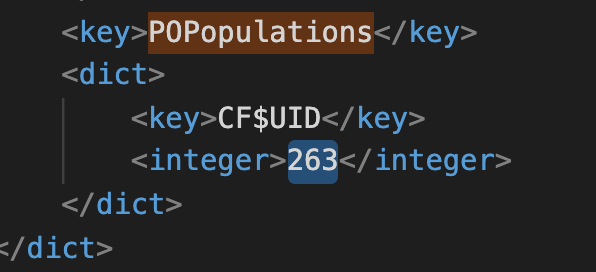


In [64]:
UID = 263
POPopulations = object_table[UID]
POPopulations

{'NS.objects': [UID: 264,
  UID: 265,
  UID: 270,
  UID: 275,
  UID: 280,
  UID: 285,
  UID: 291,
  UID: 298,
  UID: 304,
  UID: 310,
  UID: 316,
  UID: 323,
  UID: 330,
  UID: 335,
  UID: 341,
  UID: 346,
  UID: 352,
  UID: 357],
 '$class': UID: 15}

### Below, we parse the UID for each `POPopulation` from the plutil converted xml version of the WoodList 3 analysis file, then use the `create_gates_tree()` function for each of these

Notice that not all `POPopulation` objects contain an `NS.objects` reference, meaning that it does not further contain the `GMPoints` objects that we are looking for.

I hypothesize that each of these gate trees correspond to the different layouts contained within a WoodList 3 analysis file (image below)

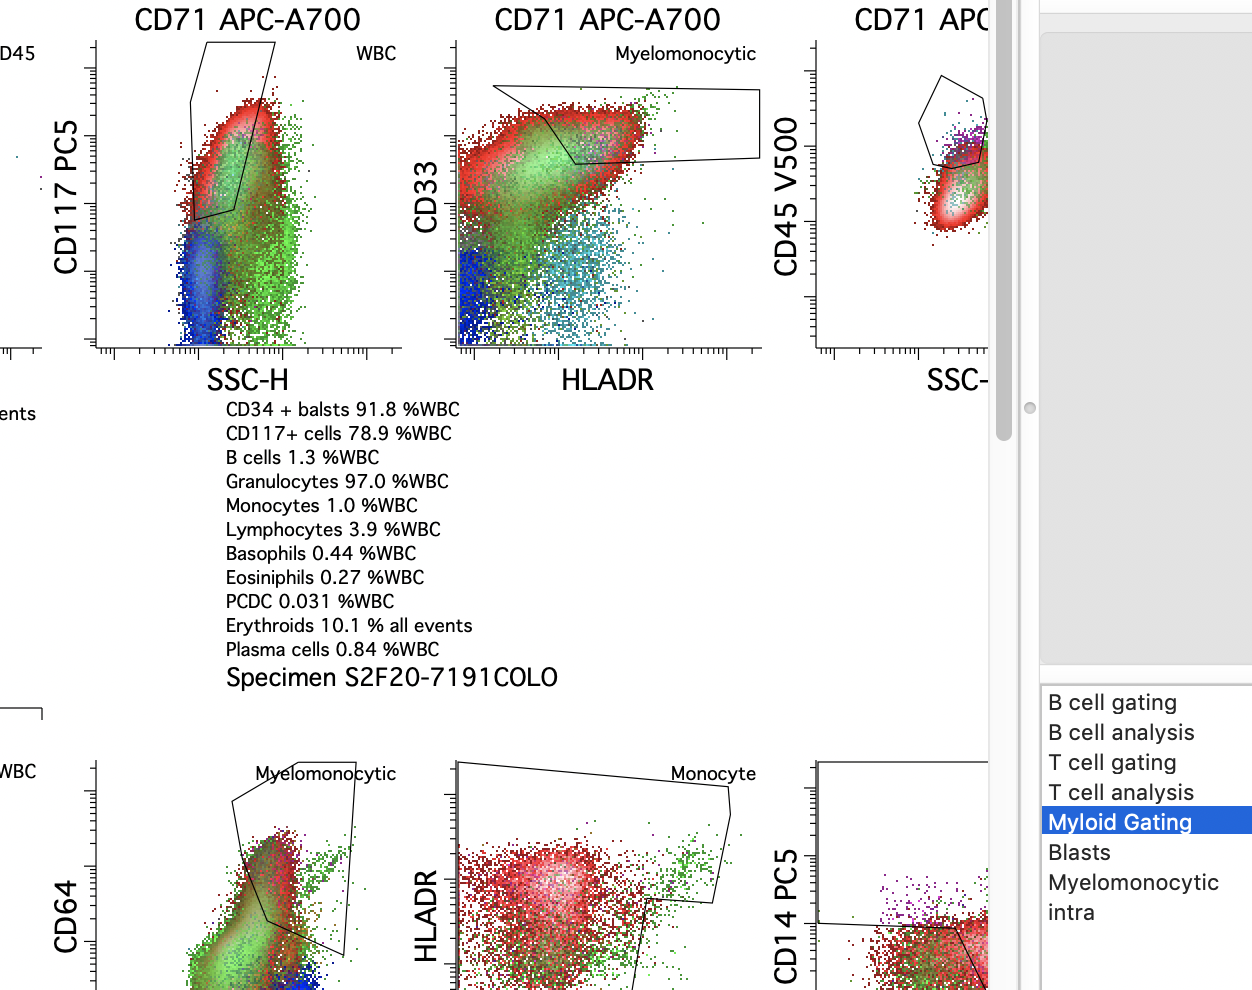

### Finally below for a given analysis file, I parse all gate trees found

In [65]:
path_to_ccl_bplist_lib = '/Users/sauterj1/Documents/Patient_Folder_Analysis/Python/'

import sys
sys.path.append(path_to_ccl_bplist_lib)

import re
import os
import struct
import ccl_bplist

gate_index = 0
total_gates = 0

def parse_gate_tree_for_uid(UID): 
  global gate_index
  global total_gates
  global gates
  
  POPopulations = object_table[UID]
  
  if 'NS.objects' not in POPopulations: 
    return("")
  
  gates = POPopulations['NS.objects']
  gate_index = 0
  total_gates = len(gates)
  
  first_gate_uid = int(str(gates[0]).split(': ')[1])
  first_gate = object_table[first_gate_uid]
  res = create_gates_tree(first_gate, 0)
  return res

f = open(Woodlist_3_nlys_file, "rb")
plist = ccl_bplist.load(f)
object_table = plist['$objects']

# gather all POPoulation UIDs
xml_filename = Woodlist_3_nlys_file.split('.')[0] + '.xml'
os.system('plutil -convert xml1 -o ' + xml_filename + ' ' + Woodlist_3_nlys_file)
xml_file = open(xml_filename, 'r')
xml_lines = xml_file.readlines()

POPopulation_in_lines = ['POPopulation' in line for line in xml_lines]
POPopulation_line_idxs = [i for i,x in enumerate(POPopulation_in_lines) if x]
POPopulation_uids = [int(re.search('<integer>[0-9]+</integer>', xml_lines[idx+3]).group(0)[9:-10]) for idx in POPopulation_line_idxs]

for uid in POPopulation_uids: 
  print("Reult for UID: " + str(uid) + '\n')
  print(parse_gate_tree_for_uid(uid))
  print('\n\n')

Reult for UID: 71

{'name': 'All Events', 'children': [{'name': 'TIME', 'children': [{'name': 'Singlets', 'children': [{'name': 'Viable', 'children': [{'name': 'Plasma cells', 'children': [{'name': 'mononuclear', 'children': [{'name': 'B cells', 'children': [{'name': 'Lambda', 'children': [], 'points': ''}, {'name': 'Lambda', 'children': [], 'points': ''}, {'name': 'Lambda', 'children': [], 'points': ''}, {'name': 'Lambda', 'children': [], 'points': ''}, {'name': 'Lambda', 'children': [], 'points': ''}, {'name': 'Lambda', 'children': [], 'points': ''}, {'name': 'Lambda', 'children': [], 'points': ''}, {'name': 'Lambda', 'children': [], 'points': ''}, {'name': 'Lambda', 'children': [], 'points': ''}, {'name': 'Lambda', 'children': [], 'points': ''}], 'points': ''}], 'points': ''}], 'points': ''}], 'points': ''}], 'points': ''}], 'points': ''}], 'points': {}}



Reult for UID: 263

{'name': 'All Events', 'children': [{'name': 'TIME', 'children': [{'name': 'Singlets', 'children': [{'name'

## Next Steps

The next steps in parsing this gating information will be to 

* Ensure that the gating trees are being parsed successfully, and possibly re-format the data structure they are stored in for simpler association between gates
* Associate X-axis feature and Y-axis feature metadata with each gate (`GMXParam` and `GMYparam` contained at the same level as `GMPoints` object. Again you will just need to do `object_table[uid]` for the uids of these param objects and they are the axis names.
  * 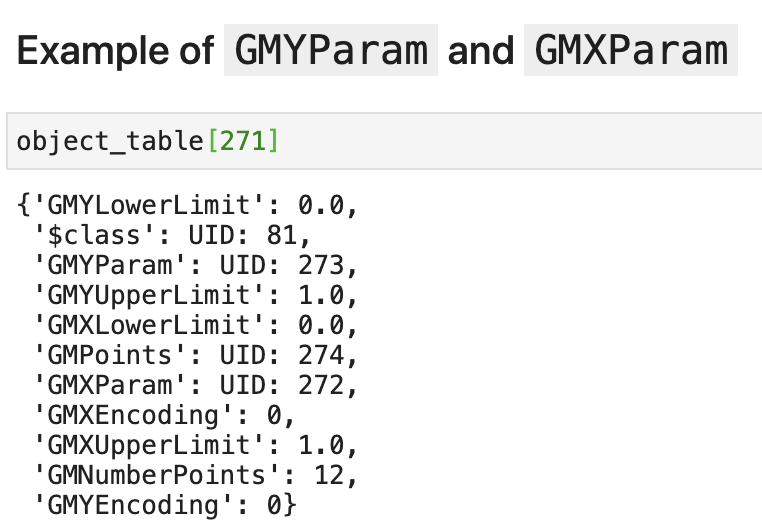
* Associate gating tree with its Woodlist "layer" name. We are interested mainly in the Myeloid (sometimes spelled Myloid in WoodList) gating information for M1.fcs and M2.fcs events. This might even be able to be performed by associating which populations are found within the gate, though the "Myloid" / "Myeloid" gating layer name might be accessible somehow relative to the gating object.
  * 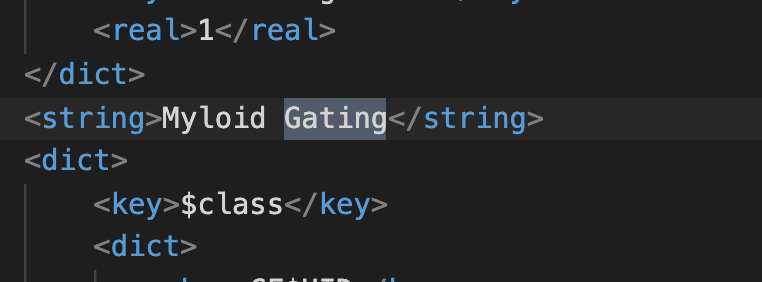
* Map(x,y) gating polygon points to compensated feature values (which might rely on previous gating steps).
  * Might be simple like `xy_points * max(compensated feature values)`, though nailing down the exact normalization value might be difficult as it might be the maximimum compensated feature value that is contained within the current gate / has not been filtered out by previous gates
* Create a method of returning the population of single cells / events given all their feature values and all the gating information parsed above
  * From a quick google `shapely` -- https://pypi.org/project/Shapely/ might be a good library to try 
  * 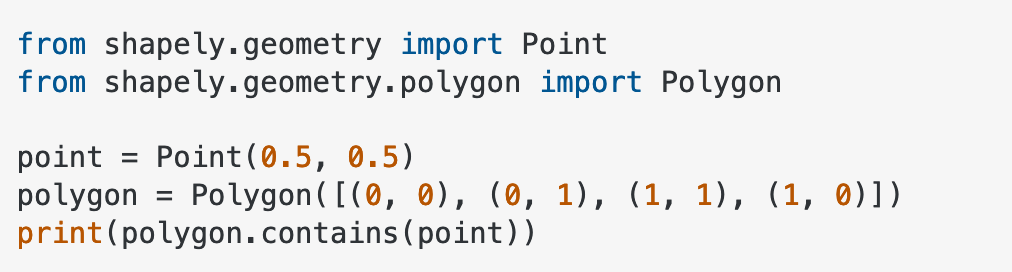

**Please feel free to reach out if you have any questions!**